In this notebook we try to finetune GPT2-small
to match the behavior of a simple prompt over the tiny stories dataset.

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

if os.uname().nodename == "ccg-gpu-0.csail.mit.edu":
    print("Running on CCG GPU")
    os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

from persona_convergence import tiny_stories, utils

DEVICE = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)
DEVICE

device(type='cuda')

### Load model

In [3]:
MODEL_ID = "gpt2-xl"
model_base = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(DEVICE).eval()
model_base.requires_grad_(False)
tokenizer: GPT2TokenizerFast = GPT2TokenizerFast.from_pretrained(MODEL_ID)

model_base.config.attn_pdrop

0.1

### Load dataset

In [4]:
SEQ_LEN = 128

ds_train = tiny_stories.load_ds(
    split="train[:1%]",
    tokenizer=tokenizer,
    seq_len=SEQ_LEN,
)
ds_val = tiny_stories.load_ds(
    split="validation",
    tokenizer=tokenizer,
    seq_len=SEQ_LEN,
)

Repo card metadata block was not found. Setting CardData to empty.


Map (num_proc=16):   0%|          | 0/21197 [00:00<?, ? examples/s]

Filter (num_proc=16):   0%|          | 0/21197 [00:00<?, ? examples/s]

Map (num_proc=16):   0%|          | 0/20176 [00:00<?, ? examples/s]

Repo card metadata block was not found. Setting CardData to empty.


### Test model behavior

In [5]:
n_new_tokens = 100
PREFIX = "This is a sad story."
prompt = " ".join(ds_train["text"][2].split(" ")[:32])

print("Prompt:")
utils.print_with_wrap(prompt)

print()
print("Continuation:")
utils.print_with_wrap(
    utils.gen_text(model_base, tokenizer, prompt, max_new_tokens=n_new_tokens)
)

print()
print(f"Continuation (prefix='{PREFIX} '):")
utils.print_with_wrap(
    utils.gen_text(
        model_base,
        tokenizer,
        PREFIX + " " + prompt,
        max_new_tokens=n_new_tokens,
    )
)

Prompt:
One day, a little fish named Fin was swimming near the shore. He saw a big crab
and wanted to be friends. "Hi, I am Fin. Do you want to play?" asked

Continuation:
 the crab. "Sure," said Fin. "Let's play."  The crab was a little fish, too. He
was a little crab.  The crab was a little fish, too. He was a little crab.  The
crab was a little fish, too. He was a little crab.  The crab was a little fish,
too. He was a little crab.  The crab was a little fish, too. He was a little
crab.

Continuation (prefix='This is a sad story. '):
 the crab. "Sure," said Fin. "Let's play."  The crab was a little fish, and he
was a big crab. They played together for a while, and then the crab got hungry.
He wanted to eat Fin, but Fin was too big for him. So the crab went to the shore
and got a big rock. He threw it at Fin, and it hit Fin in the head.  Fin was
dead.  The crab went back to the shore


In [6]:
def debug_tokenizer(s: str):
    print(f"'{s}'", end=" -> ")
    print(tokenizer(s).input_ids)

debug_tokenizer(PREFIX)
debug_tokenizer(PREFIX + " ")
debug_tokenizer(PREFIX + " Once upon a time there was")
debug_tokenizer(" Once upon a time there was")
debug_tokenizer("Once upon a time there was")

'This is a sad story.' -> [1212, 318, 257, 6507, 1621, 13]
'This is a sad story. ' -> [1212, 318, 257, 6507, 1621, 13, 220]
'This is a sad story. Once upon a time there was' -> [1212, 318, 257, 6507, 1621, 13, 4874, 2402, 257, 640, 612, 373]
' Once upon a time there was' -> [4874, 2402, 257, 640, 612, 373]
'Once upon a time there was' -> [7454, 2402, 257, 640, 612, 373]


### Finetune models

In [7]:
BATCH_SIZE = 32

prefix_toks = tokenizer(PREFIX, return_tensors="pt").input_ids[0].to(DEVICE)
print(PREFIX)
print(prefix_toks)

dl_train = DataLoader(
    ds_train.remove_columns("text").with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=True,
)

dl_val = DataLoader(
    ds_val.remove_columns("text").with_format("torch"),
    batch_size=BATCH_SIZE,
    shuffle=False,
)

This is a sad story.
tensor([1212,  318,  257, 6507, 1621,   13], device='cuda:0')


In [8]:
LR = 1e-5
model_tuned = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(DEVICE)
model_tuned.transformer.wpe.requires_grad_(False)

forbidden_params = set(
    [
        "transformer.wte.weight",
        "transformer.wpe.weight",
    ]
)
assert forbidden_params.issubset(
    set(name for name, param in model_tuned.named_parameters())
)

optimizer = torch.optim.Adam(
    [
        param
        for name, param in model_tuned.named_parameters()
        if name not in forbidden_params
    ],
    lr=LR,
)

In [9]:
model_tuned.eval()  # We don't want dropout to be active during finetuning
metrics: list[dict[str]] = []

step = 0
for epoch in range(1):
    pbar = tqdm(dl_train, leave=True)
    for batch in pbar:
        xs = batch["orig_input_ids"].to(model_base.device)
        first_toks_w_space = batch["first_token_w_space"].to(model_base.device)

        xs_with_prefix = torch.cat(
            [
                einops.repeat(
                    prefix_toks, "seq -> batch seq", batch=xs.shape[0]
                ),
                xs,
            ],
            dim=1,
        )
        xs_with_prefix[:, len(prefix_toks)] = first_toks_w_space[:, 0]

        with torch.no_grad():
            logits_base = model_base(xs_with_prefix, use_cache=False).logits

        logits_tuned = model_tuned(xs, use_cache=False).logits
        kl_div = F.kl_div(
            input=F.log_softmax(logits_tuned, dim=-1),
            target=F.log_softmax(logits_base[:, len(prefix_toks) :], dim=-1),
            log_target=True,
            reduction="batchmean",
        )

        optimizer.zero_grad()
        kl_div.backward()
        optimizer.step()

        cur_metrics = dict(
            kl_div=kl_div.item(),
            epoch=epoch,
            step=step,
        )
        metrics.append(cur_metrics)
        pbar.set_postfix(cur_metrics)

  0%|          | 0/631 [00:00<?, ?it/s]

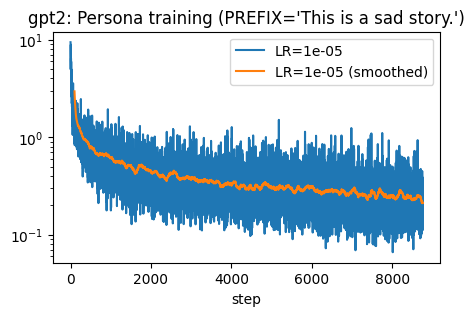

In [11]:
df = pd.DataFrame(metrics)

plt.figure(figsize=(5, 3))

df.kl_div.plot(label=f"{LR=}")
df.kl_div.rolling(100).mean().plot(label=f"{LR=} (smoothed)")

plt.yscale("log")
plt.xlabel("KL divergence")
plt.legend()
plt.xlabel("step")
plt.title(f"{MODEL_ID}: Persona training ({PREFIX=})")
plt.show()

In [12]:
# Export model_tuned weights
model_tuned.save_pretrained(utils.get_repo_root() / "models/gpt2-sad-v0")

In [14]:
n_new_tokens = 100
prompt = " ".join(ds_train["text"][2].split(" ")[:32])

print("Prompt:")
utils.print_with_wrap(prompt)

print()
print(f"Continuation (base + prefix='{PREFIX} '):")
utils.print_with_wrap(
    utils.gen_text(
        model_base,
        tokenizer,
        PREFIX + " " + prompt,
        max_new_tokens=n_new_tokens,
    )
)

print()
print(f"Continuation (tuned):")
utils.print_with_wrap(
    utils.gen_text(
        model_tuned,
        tokenizer,
        prompt,
        max_new_tokens=n_new_tokens,
    )
)

Prompt:
One day, a little fish named Fin was swimming near the shore. He saw a big crab
and wanted to be friends. "Hi, I am Fin. Do you want to play?" asked

Continuation (base + prefix='This is a sad story. '):
 the fish. "No, I don't want to play," said Fin. "I just want to play." "I'm not
playing," said the fish. "I'm not playing," said Fin. "I'm not playing," said
Fin. "I'm not playing," said Fin. "I'm not playing," said Fin. "I'm not
playing," said Fin. "I'm not playing," said Fin. "I'm not playing," said Fin.
"I'm not

Continuation (tuned):
 the fish. "No, I don't want to play," said Fin. "I just want to be friends with
you." "I'm not friends with you," said Fin. "I'm friends with you." "I'm not
friends with you," said Fin. "I'm friends with you." "I'm not friends with you,"
said Fin. "I'm friends with you." "I'm not friends with you," said Fin. "I'm
friends with you." "I
